<a href="https://colab.research.google.com/github/hemanthpoojar21-maker/Uber-trip-analysis-project/blob/main/Uber_trip_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
import joblib
try:
    import xgboost as xgb
    HAS_XGB = True
except:
    HAS_XGB = False


In [2]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [5]:
from google.colab import files
import pandas as pd
import numpy as np
from pathlib import Path

uploaded = files.upload()  # manually upload Uber-Jan-Feb-FOIL (1).csv when prompted
filename = list(uploaded.keys())[0]  # get the uploaded file name
DATA_PATH = Path(filename)
print("Loaded file:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]


Saving Uber-Jan-Feb-FOIL (1).csv to Uber-Jan-Feb-FOIL (1) (1).csv
Loaded file: Uber-Jan-Feb-FOIL (1) (1).csv


In [6]:
def parse_dates_safely(series):
    for fmt in ("%m-%d-%Y %H:%M:%S","%m/%d/%Y %H:%M:%S","%Y-%m-%d %H:%M:%S","%d-%m-%Y %H:%M:%S",
                "%m-%d-%Y","%d-%m-%Y","%Y-%m-%d","%m/%d/%Y","%d/%m/%Y"):
        try:
            return pd.to_datetime(series, format=fmt)
        except:
            pass
    return pd.to_datetime(series, infer_datetime_format=True, errors='coerce')

if 'date' in df.columns:
    df['date'] = parse_dates_safely(df['date'])
else:
    raise KeyError("Expected a 'date' column in the CSV")
df = df.dropna(subset=['date']).copy()
for col in ['trips','active_vehicles']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)


In [7]:
df = df.sort_values('date').reset_index(drop=True)
has_time = not (df['date'].dt.time == pd.to_datetime('00:00').time()).all()
if has_time:
    df = df.set_index('date')
    series = df.groupby(pd.Grouper(freq='H')).agg({'trips':'sum'})
    series = series['trips'].fillna(0)
    freq = 'H'
    window_size = 24
else:
    df = df.set_index('date')
    series = df.groupby(pd.Grouper(freq='D')).agg({'trips':'sum'})
    series = series['trips'].fillna(0)
    freq = 'D'
    window_size = 7
series = series.sort_index()


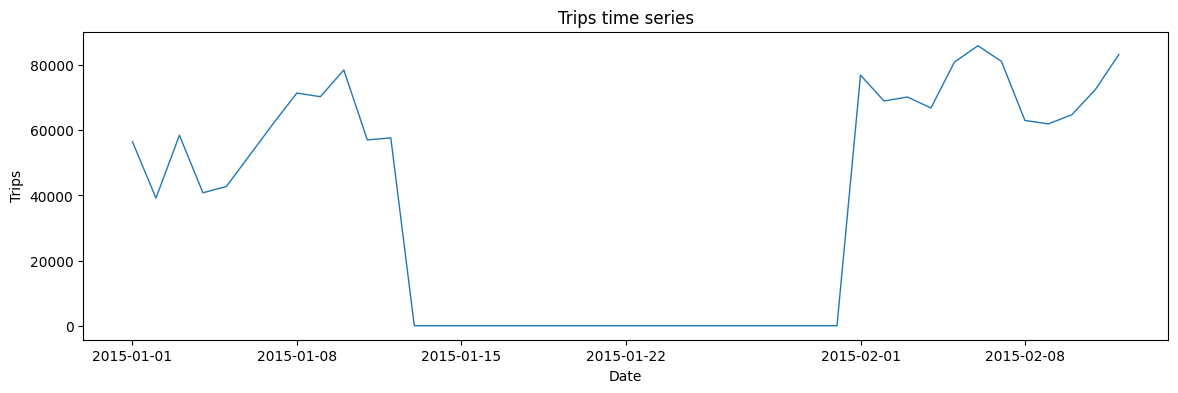

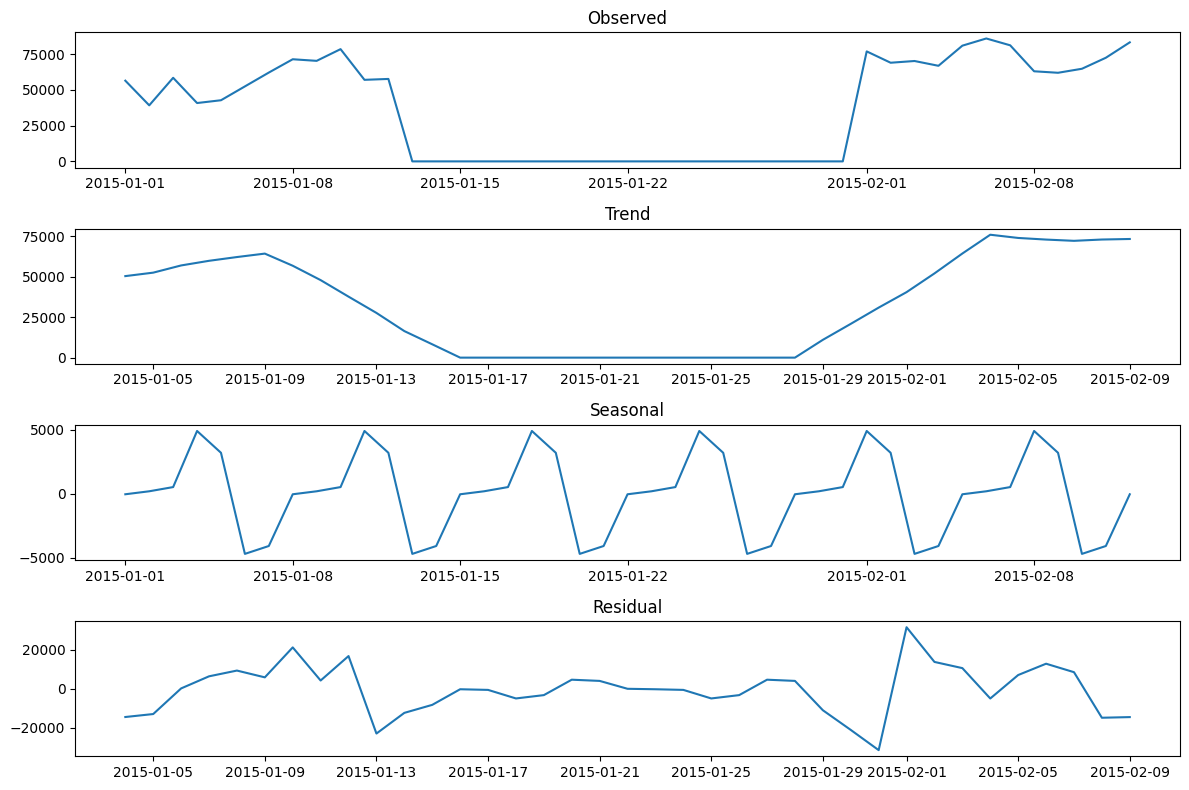

In [8]:
plt.figure(figsize=(14,4))
plt.plot(series.index, series.values, linewidth=1)
plt.title('Trips time series')
plt.xlabel('Date')
plt.ylabel('Trips')
plt.show()

period = 24 if freq=='H' else 7
try:
    result = seasonal_decompose(series, model='add', period=period)
    plt.figure(figsize=(12,8))
    plt.subplot(411); plt.plot(result.observed); plt.title('Observed')
    plt.subplot(412); plt.plot(result.trend); plt.title('Trend')
    plt.subplot(413); plt.plot(result.seasonal); plt.title('Seasonal')
    plt.subplot(414); plt.plot(result.resid); plt.title('Residual')
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Seasonal decomposition failed:", e)


In [9]:
def create_lagged_features(data_array, window_size):
    X, y = [], []
    for i in range(len(data_array) - window_size):
        X.append(data_array[i:i+window_size])
        y.append(data_array[i+window_size])
    return np.array(X), np.array(y)

series_values = series.values
X_all, y_all = create_lagged_features(series_values, window_size)
dates_all = series.index[window_size:]


In [10]:
split_idx = int(len(X_all)*0.8)
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]
dates_train, dates_test = dates_all[:split_idx], dates_all[split_idx:]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
models_preds = {}
models_mape = {}
models_rmse = {}

if HAS_XGB:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    param_grid = {
        'n_estimators':[100,200,300],
        'max_depth':[3,6],
        'learning_rate':[0.01,0.1],
        'subsample':[0.6,0.8,1.0],
        'colsample_bytree':[0.6,0.8,1.0]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    scorer = make_scorer(lambda y_true,y_pred: -mape(y_true,y_pred))
    xgb_gs = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring=scorer, n_jobs=-1, verbose=1)
    xgb_gs.fit(X_train_scaled, y_train)
    xgb_best = xgb_gs.best_estimator_
    xgb_pred = xgb_best.predict(X_test_scaled)
    models_preds['xgb'] = xgb_pred
    models_mape['xgb'] = mape(y_test, xgb_pred)
    models_rmse['xgb'] = rmse(y_test, xgb_pred)
    joblib.dump(xgb_best, "xgb_best.joblib")
else:
    print("XGBoost not installed. Skipping XGBoost.")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [13]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param = {
    'n_estimators':[100,200],
    'max_depth':[None,10,30],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2]
}
tscv = TimeSeriesSplit(n_splits=5)
scorer = make_scorer(lambda y_true,y_pred: -mape(y_true,y_pred))
rf_gs = GridSearchCV(rf, rf_param, cv=tscv, scoring=scorer, n_jobs=-1, verbose=1)
rf_gs.fit(X_train_scaled, y_train)
rf_best = rf_gs.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)
models_preds['rf'] = rf_pred
models_mape['rf'] = mape(y_test, rf_pred)
models_rmse['rf'] = rmse(y_test, rf_pred)
joblib.dump(rf_best, "rf_best.joblib")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


['rf_best.joblib']

In [14]:
gbr = GradientBoostingRegressor(random_state=42)
gbr_param = {
    'n_estimators':[100,200,300],
    'learning_rate':[0.01,0.1],
    'max_depth':[3,5],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2]
}
tscv = TimeSeriesSplit(n_splits=5)
scorer = make_scorer(lambda y_true,y_pred: -mape(y_true,y_pred))
gbr_gs = GridSearchCV(gbr, gbr_param, cv=tscv, scoring=scorer, n_jobs=-1, verbose=1)
gbr_gs.fit(X_train_scaled, y_train)
gbr_best = gbr_gs.best_estimator_
gbr_pred = gbr_best.predict(X_test_scaled)
models_preds['gbr'] = gbr_pred
models_mape['gbr'] = mape(y_test, gbr_pred)
models_rmse['gbr'] = rmse(y_test, gbr_pred)
joblib.dump(gbr_best, "gbr_best.joblib")


Fitting 5 folds for each of 48 candidates, totalling 240 fits


['gbr_best.joblib']

In [15]:
for name in models_preds:
    print(name.upper(), "MAPE:", f"{models_mape[name]:.2f}%", "RMSE:", f"{models_rmse[name]:.2f}")


XGB MAPE: 27.05% RMSE: 23400.35
RF MAPE: 18.25% RMSE: 15294.84
GBR MAPE: 14.31% RMSE: 13337.13


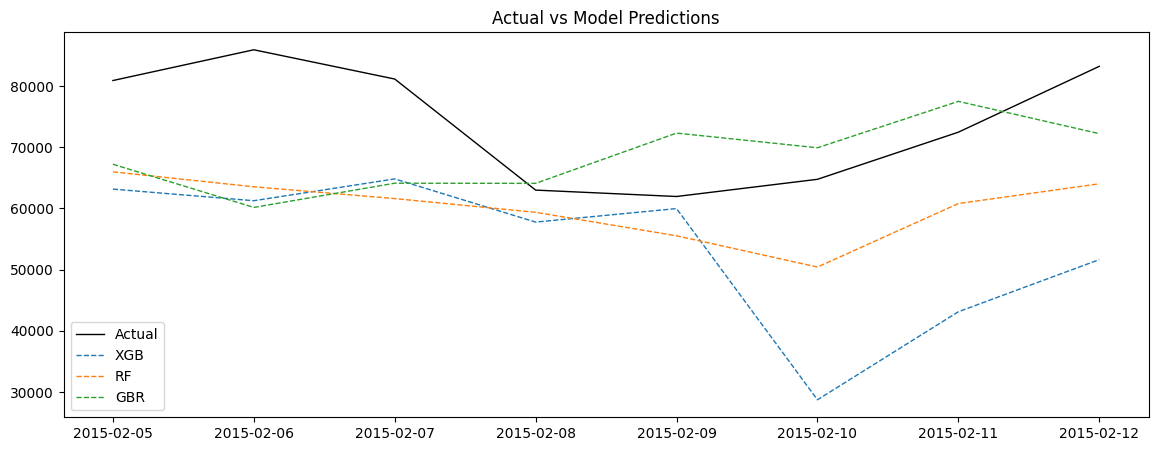

In [16]:
plt.figure(figsize=(14,5))
plt.plot(dates_test, y_test, label='Actual', color='black', linewidth=1)
colors = {'xgb':'red','rf':'green','gbr':'orange'}
for name, pred in models_preds.items():
    plt.plot(dates_test, pred, label=name.upper(), linestyle='--', linewidth=1)
plt.legend()
plt.title('Actual vs Model Predictions')
plt.show()


In [17]:
available = [k for k in models_preds.keys()]
mape_vals = np.array([models_mape[k] for k in available])
recip = 1.0 / (mape_vals + 1e-8)
weights = recip / recip.sum()
ensemble_pred = np.zeros_like(y_test, dtype=float)
for w, k in zip(weights, available):
    ensemble_pred += w * models_preds[k]
ensemble_mape = mape(y_test, ensemble_pred)
ensemble_rmse = rmse(y_test, ensemble_pred)
print("Ensemble MAPE:", f"{ensemble_mape:.2f}%", "Ensemble RMSE:", f"{ensemble_rmse:.2f}")


Ensemble MAPE: 15.70% Ensemble RMSE: 14465.31


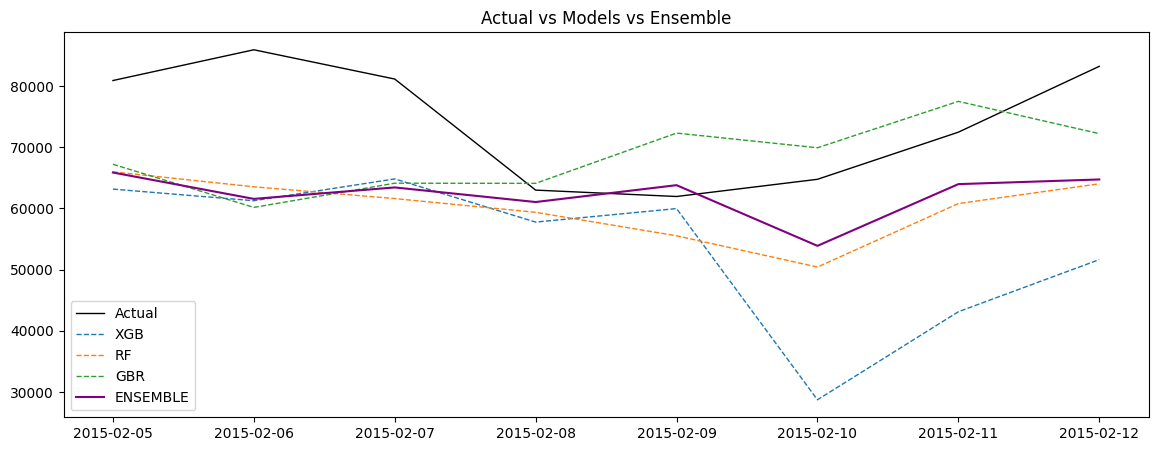

In [18]:
plt.figure(figsize=(14,5))
plt.plot(dates_test, y_test, label='Actual', color='black', linewidth=1)
for name, pred in models_preds.items():
    plt.plot(dates_test, pred, label=name.upper(), linestyle='--', linewidth=1)
plt.plot(dates_test, ensemble_pred, label='ENSEMBLE', linestyle='-', linewidth=1.5, color='purple')
plt.legend()
plt.title('Actual vs Models vs Ensemble')
plt.show()


In [19]:
out_df = pd.DataFrame({'date':dates_test, 'actual':y_test})
for k in models_preds:
    out_df[k+'_pred'] = models_preds[k]
out_df['ensemble_pred'] = ensemble_pred
out_df = out_df.set_index('date')
out_df.to_csv("uber_models_test_predictions.csv")
joblib.dump(scaler, "scaler.joblib")
print("Saved uber_models_test_predictions.csv and model files.")


Saved uber_models_test_predictions.csv and model files.
